# Deep Learning for Computer Vision

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Florient Chouteau | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

## Session 1 : About Convolutions and CNNs ...

Welcome to this BE about applying Deep Learning for Computer Vision

We have 6 hours to do an hands on with something that looks like what you could be doing in three months time (but simplified)

We have four notebooks to go through during those 6 hours :

- One general for to get a better grasp about CNNs (it should be very quick)
- One where we will train a small aircraft classifier on a "simple" dataset and plot performance curves
- One where we will train an aircraft classifier on a more realistic dataset and plot performance curves
- The last one we will take our previously trained model and use it for real ;)

It is recommended to use Google Colab to run these notebooks

## Images

A digital image is an image composed of picture elements, also known as pixels, each with finite, discrete quantities of numeric representation for its intensity or gray level that is an output from its two-dimensional functions fed as input by its spatial coordinates denoted with x, y on the x-axis and y-axis, respectively.

We represent images as matrixes,

Images are made of pixels, and pixels are made of combinations of primary colors (in our case Red, Green and Blue). In this context, images have chanels that are the grayscale image of the same size as a color image, made of just one of these primary colors. For instance, an image from a standard digital camera will have a red, green and blue channel. A grayscale image has just one channel.

In remote sensing, channels are often referred to as raster bands.

<img src="https://miro.medium.com/max/1400/1*icINeO4H7UKe3NlU1fXqlA.jpeg" alt="drawing" width="400"/>

For the rest of this workshop we will use the following axis conventions for images

![conventions](https://storage.googleapis.com/fchouteau-isae-deep-learning/static/image_coordinates.png)

The reference library in python for working with images is https://scikit-image.org/

We will just do basic image manipulation, but you [can look at all the examples](https://scikit-image.org/docs/stable/auto_examples/) if you need to get a better grasp of image processing

In [24]:
import numpy as np
import skimage
import skimage.data
from matplotlib import pyplot as plt

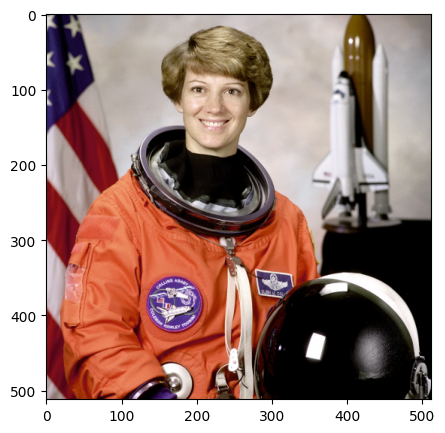

In [25]:
img = skimage.data.astronaut()

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()

In [26]:
# What is the height, width and number of channels of this image ?
# In which order is the data represented ? Which dimensions are channels in ?
# What is the image "dtype" ?

In [27]:
print(img.shape) #nb de canaux, hauteur, largeur

print(img.dtype)

(512, 512, 3)
uint8


In [28]:
#chgt de l'ordre

img_reordered = np.transpose(img, (1, 2, 0))   # devient (512,512,3)


In [29]:
# Extract the center 128 x 128 pixels on all three bands and plot it

/tmp/ipython-input-4292310129.py:11: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[i].imshow(img_crop[:, :, i], cmap = 'gray') #cmap : transforme les valeurs d’un tableau en couleurs quand on affiche une image


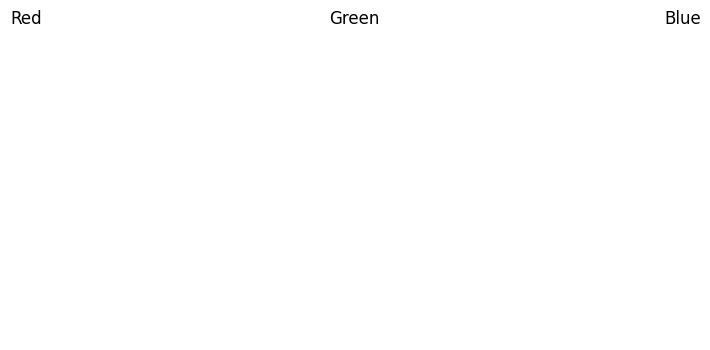

In [30]:
start = (img.shape[1] - 128) // 2
end = start + 128

img_crop = img_reordered[start:end, start:end,:]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

titles = ["Red", "Green", "Blue"]

for i in range(3):
    axes[i].imshow(img_crop[:, :, i], cmap = 'gray') #cmap : transforme les valeurs d’un tableau en couleurs quand on affiche une image
    axes[i].set_title(titles[i])
    axes[i].axis('off')

plt.show()


In classical image representation, we use the [RGB color model](https://en.wikipedia.org/wiki/RGB_color_model) where the image is represented by three R,G,B channels (in that order).

Usually we also use 8bits color depth

In [31]:
# Plot the difference between the green and the red band
# don't forget to convert the image type as the image are in unsigned type

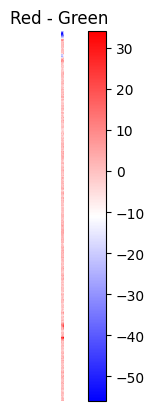

In [32]:
#on convertit les bandes pour pouvoir ensuite faire la différence : le type uint8 ne peut pas prendre des valeurs négatives
green = img_reordered[:,:,1].astype(np.int16)
red = img_reordered[:,:,0].astype(np.int16)

diff = red - green

#afficher la diff
plt.imshow(diff, cmap='bwr')
plt.colorbar()
plt.title("Red - Green ")
plt.axis('off')
plt.show()




## Convolutions

You've seen this image in the previous class :

<img src="https://raw.githubusercontent.com/SupaeroDataScience/deep-learning/refs/heads/main/vision/FjvuN.gif" alt="drawing" width="400"/>

This is a convolution operator.

Someone may have told you that CNNs were the "thing" that made deep learning for image processing possible. But what are convolutions ?

First, remember that you [learnt about convolutions a long time ago 😱](https://fr.wikipedia.org/wiki/Produit_de_convolution)

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b9/Convolution_of_spiky_function_with_box2.gif" alt="drawing" width="400"/>

So basically, we slide a filter over the signal. In 2D, this means

<img src="https://miro.medium.com/max/535/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" alt="drawing" width="400"/>

One thing you can notice is that if we slide a filter over an image we "lose" pixels at the border. This is actually quite easy to compute : assuming a of size `2*k +1` we loose `k` pixels on each side of the image.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

If you want to get them back you have to "pad" (add values at the border, for examples zeroes) the image

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/arbitrary_padding_no_strides.gif)

For more information, this website is excellent : https://cs231n.github.io/convolutional-networks/#conv

Let's play with convolutions a little bit before actually doing CNNs.

### 2D Convolution without "depth"

First, let's look at basic filtering over grayscale (1 channel) images. We will slide a filter over H,W spatial dimensions and get the result

First, the convolution implementation without depth is quite simple :

In [33]:
def convolve(img: np.array, kernel: np.array) -> np.array:
    k = kernel.shape[0]
    h, w = img.shape[:2]
    p = int(k // 2)

    # 2D array of zeros
    kernel = kernel.astype(np.float32)
    img = img.astype(np.float32)
    convolved_img = np.zeros(shape=(h - 2 * p, w - 2 * p)).astype(np.float32)

    # Iterate over the rows
    for i in range(h - 2 * p):
        # Iterate over the columns
        for j in range(w - 2 * p):
            # img[i, j] = individual pixel value
            # Get the current matrix
            mat = img[i : i + k, j : j + k]

            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))

    convolved_img = convolved_img.clip(0.0, 255.0).astype(np.uint8)

    return convolved_img

What happens if I use this filter as input ?

![identity](https://wikimedia.org/api/rest_v1/media/math/render/svg/1fbc763a0af339e3a3ff20af60a8a993c53086a7)

In [34]:
k = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
k = np.asarray(k)

k.shape
print(k)

[[0 0 0]
 [0 1 0]
 [0 0 0]]


(300, 451)


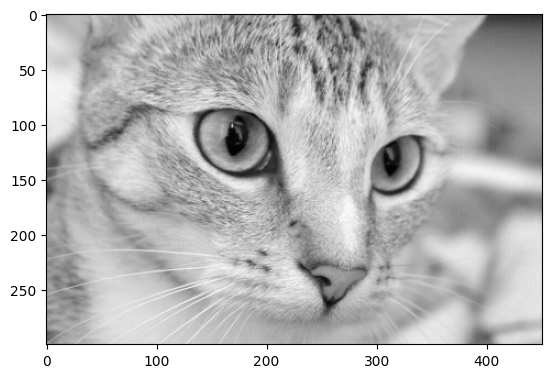

In [35]:
img = skimage.data.cat()
img = img[:, :, 0]

print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()

(298, 449)


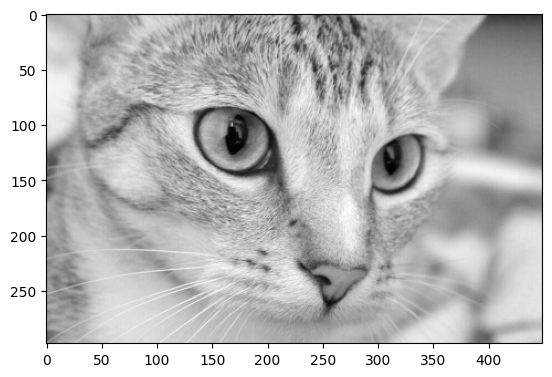

before (302, 453)
after (300, 451)


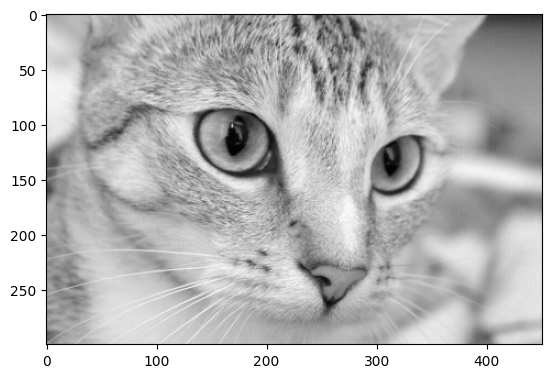

In [36]:
convolved_img = convolve(img, k)

print(convolved_img.shape)

plt.imshow(convolved_img, cmap="gray")
plt.show()

# Note the loss of 1 pixel... If we wanted to alleviate it we could do something like

img = np.pad(img, ((1, 1), (1, 1))) #ajoute une ligne en haut et ligne en bas ; une ligne à gauche et une ligne à droite
print(f"before {img.shape}")
convolved_img = convolve(img, k)

print(f"after {convolved_img.shape}")

plt.imshow(convolved_img, cmap="gray")
plt.show()

Too easy ! Let's try another filter

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/91256bfeece3344f8602e288d445e6422c8b8a1c)

What does it do ? Take a guess

In [37]:
k = np.asarray([[1, 1, 1], [1, 1, 1], [1, 1, 1]]).astype(np.float32)
k = k / k.sum()
print(k)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


In [38]:
# Convolve the cat image with this filter and plot it

In [39]:
img = skimage.data.cat()
img = img[:, :, 0]

convolved_img = convolve(img, k)

(298, 449)


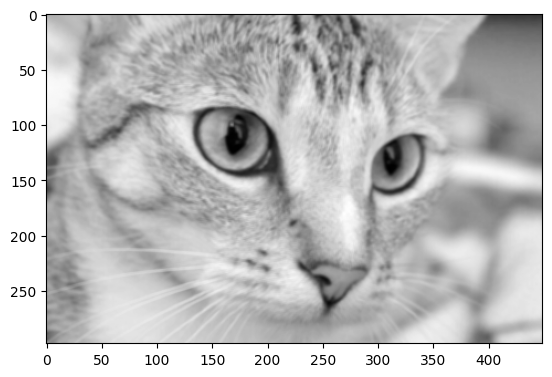

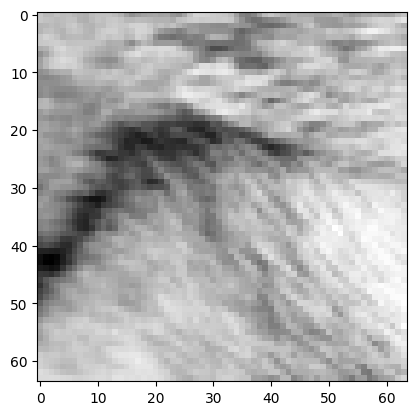

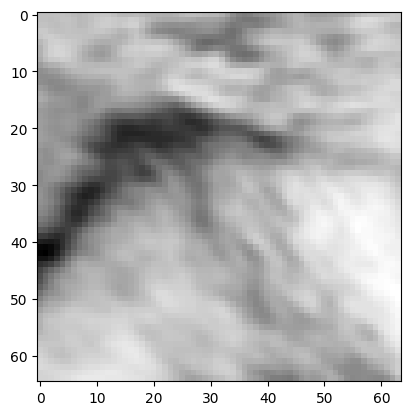

In [40]:
print(convolved_img.shape)

plt.imshow(convolved_img, cmap="gray")
plt.show()

plt.imshow(img[64:128, 64:128], cmap="gray")
plt.show()
plt.imshow(convolved_img[64:129, 64:128], cmap="gray")
plt.show()

If we wanted, we could learn the filters in order to do... cat classification !

There are many more filters that have been designed to do interesting things, you can find an interesting list here : https://en.wikipedia.org/wiki/Kernel_(image_processing)

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2141203%2F99dba888571cd6284b9b59903061aaa4%2Fko001.png?generation=1591783791920610&alt=media)

**Takeaway message** : Kernel filtering (convolution) takes its root from classical image processing !

### Convolutions with depth

Let's get back to our GIF

<img src="https://raw.githubusercontent.com/SupaeroDataScience/deep-learning/refs/heads/main/vision/FjvuN.gif" alt="drawing" width="400"/>

It's the same as above, except our filter takes all channels of the image as input. So basically a "Convolution" layer is a filter

**Important**

In classical image processing, we use the (height, width, channels) convention, however in torch we prefer using (channels, height, width) convention

In [41]:
img = skimage.data.astronaut()
img.shape

(512, 512, 3)

In [42]:
# To transpose an image, we use
img = img.transpose((2, 0, 1))  # change channel order
img.shape

(3, 512, 512)

In [48]:
w = np.random.random((1, 3, 3, 3))
b = np.random.random((3,))

In [44]:
# You should remember this from the previous class, this is the general implementation of convolutions


def forward_convolution(conv_W, conv_b, data):
    """
    Compute the output from a convolutional layer given the weights and data.

    conv_W is of the shape (# output channels, # input channels, convolution width, convolution height )
    output_channels is the number of filters in the convolution

    conv_b is of the shape (# output channels)

    data is of the shape (# input channels, width, height)

    The output should be the result of a convolution and should be of the size:
        (# output channels, width - convolution width + 1, height -  convolution height + 1)

    Returns:
        The output of the convolution as a numpy array
    """

    conv_channels, _, conv_width, conv_height = conv_W.shape

    input_channels, input_width, input_height = data.shape

    output = np.zeros(
        (conv_channels, input_width - conv_width + 1, input_height - conv_height + 1)
    )

    for x in range(input_width - conv_width + 1):
        for y in range(input_height - conv_height + 1):
            for output_channel in range(conv_channels):
                output[output_channel, x, y] = (
                    np.sum(
                        np.multiply(
                            data[:, x : (x + conv_width), y : (y + conv_height)],
                            conv_W[output_channel, :, :, :],
                        )
                    )
                    + conv_b[output_channel]
                )

    return output

In [45]:
# Convolve the input with the weights and bias

In [49]:
output = forward_convolution(w,b,img)

Input (3, 512, 512)
Filter:
 [[[[0.37368732 0.41590931 0.16055935]
   [0.47549616 0.83757339 0.48029628]
   [0.08082056 0.09649107 0.4941271 ]]

  [[0.08026406 0.85613684 0.24100076]
   [0.42837273 0.57419787 0.93896866]
   [0.76050434 0.57537141 0.57214219]]

  [[0.24811994 0.77342677 0.29696965]
   [0.44558348 0.72493206 0.73953442]
   [0.4720273  0.75476153 0.10258198]]]] 
 (1, 3, 3, 3)
Bias: [0.61342311 0.67705844 0.69400313] (3,)
Input (1, 510, 510)


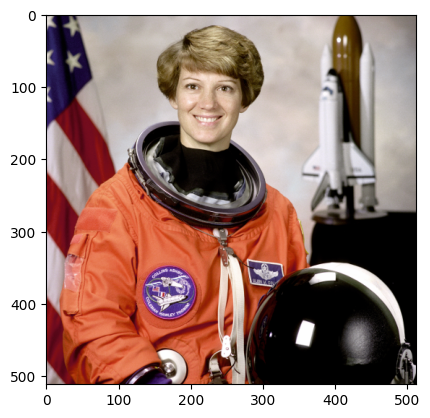

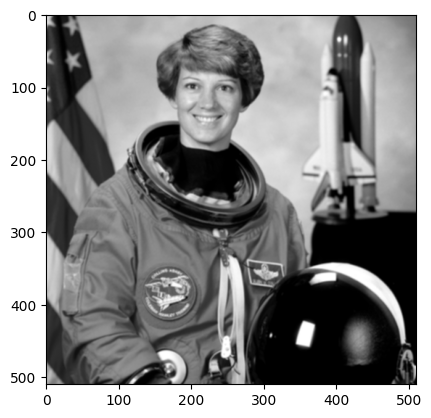

In [50]:
print("Input", img.shape)
print(f"Filter:\n {w} \n {w.shape}")
print("Bias:", b, b.shape)
print("Input", output.shape)

# Don't forget that matplotlib uses (h,w,c) to plot images !
plt.imshow(img.transpose((1, 2, 0)))
plt.show()
plt.imshow(output.transpose((1, 2, 0))[:, :, 0], cmap="gray")
plt.show()

Some useful resources for more information :

- The DL class https://github.com/fchouteau/deep-learning/blob/main/deep/Deep%20Learning.ipynb
- https://github.com/vdumoulin/conv_arithmetic
- https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1

## Convolutional Neural Networks

I shamelessly copy pasted code from this excellent class : https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb

Remember, an Artificial Neural Network is a stack of

- "Fully Connected" layers
- Non linearities

A Convolutional Neural Network is a stack of
- Convolutional Layers aka Filter Banks
    - Increase dimensionality
    - Projection on overcomplete basis
    - Edge detections
- Non-linearities
    - Sparsification
    - Typically Rectified Linear Unit (ReLU): ReLU(x)=max⁡(x,0)\text{ReLU}(x) = \max(x, 0)ReLU(x)=max(x,0)
- Pooling
    - Aggregating over a feature map
    - Example : Maximum

![](https://cdn-media-1.freecodecamp.org/images/Dgy6hBvOvAWofkrDM8BclOU3E3C2hqb25qBb)

<img src="https://production-media.paperswithcode.com/methods/MaxpoolSample2.png" alt="drawing" width="400"/>

Max pooling operations

Why do CNNs works ?

To perform well, we need to incorporate some prior knowledge about the problem

    Assumptions helps us when they are true
    They hurt us when they are not
    We want to make just the right amount of assumptions, not more than that
    
In Deep Learning

    Many layers: compositionality
    Convolutions: locality + stationarity of images
    Pooling: Invariance of object class to translations

### Definitions

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [52]:
input_size = 28 * 28  # images are 28x28 pixels
output_size = 10  # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    ),
    batch_size=64,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data",
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    ),
    batch_size=1000,
    shuffle=True,
)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.93MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.57MB/s]


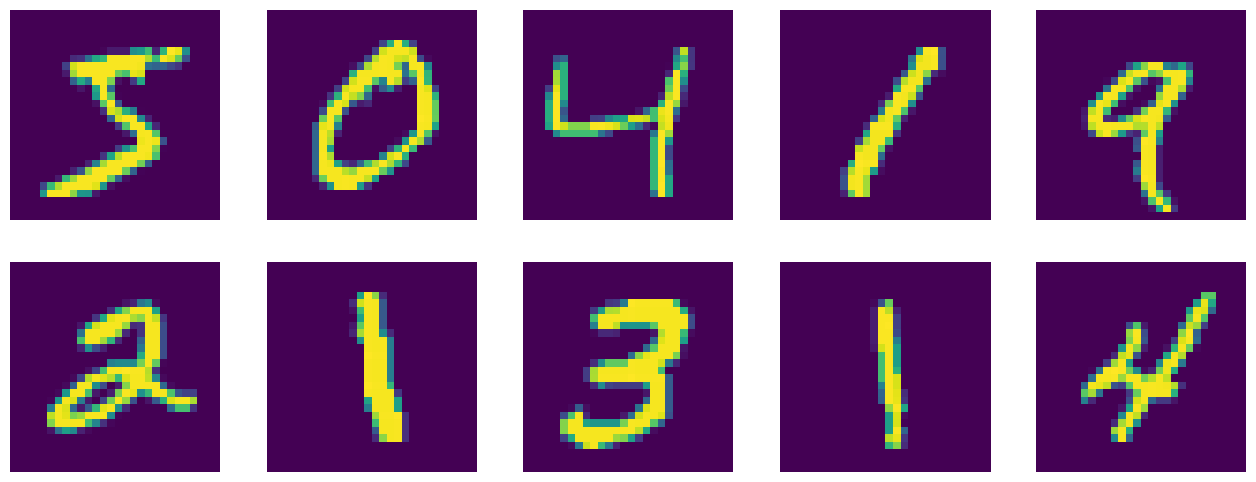

In [53]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis("off");

In [56]:
# function to count number of parameters
def get_n_params(model):
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np


# Create two models: One ANN vs One CNN
class FullyConnected2Layers(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FullyConnected2Layers, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)


class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(n_feature, n_feature, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(n_feature * 4 * 4, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x, verbose=False):
        return self.network(x)

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [57]:
# Apple Silicon Support
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
# NVIDIA GPU
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
# Fallback to CPU
else:
    device = torch.device("cpu")

print(device)

cpu


In [58]:
accuracy_list = []

In [59]:
def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28 * 28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )


def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28 * 28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(
            output, target, reduction="sum"
        ).item()  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[
            1
        ]  # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), accuracy
        )
    )

### CNNs vs Fully Connected Layers

A small FullyConnected ANN

In [60]:
n_hidden = 8  # number of hidden units

model_fnn = FullyConnected2Layers(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)

print("Number of parameters: {}".format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.319203
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.096551
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.429070
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.993486
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.714577
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.880915
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.456139
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.546173
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.486337
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.439415

Test set: Average loss: 0.4144, Accuracy: 8803/10000 (88%)



A CNN with the same number of parameters

In [63]:
# Training settings
n_features = 6  # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

print("Number of parameters: {}".format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.307697
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.758392
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.601606
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.296010
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.259083
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.144805
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.287556
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.427982
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.253720
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.177230

Test set: Average loss: 0.1750, Accuracy: 9452/10000 (95%)



The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

    Use of convolution: Locality and stationarity in images
    Pooling: builds in some translation invariance

### What happens when CNNs assumptions are not true ?

We will deterministically permute pixels so that the content of an image is respected but not its structure

Basically transform some positions into others, so that the spatial relationship between pixels is not respected anymore

And we will train networks on this : A CNN (convolutional) and a ANN (fully connected)

We will then check what results the two different architectures are getting on each dataset.

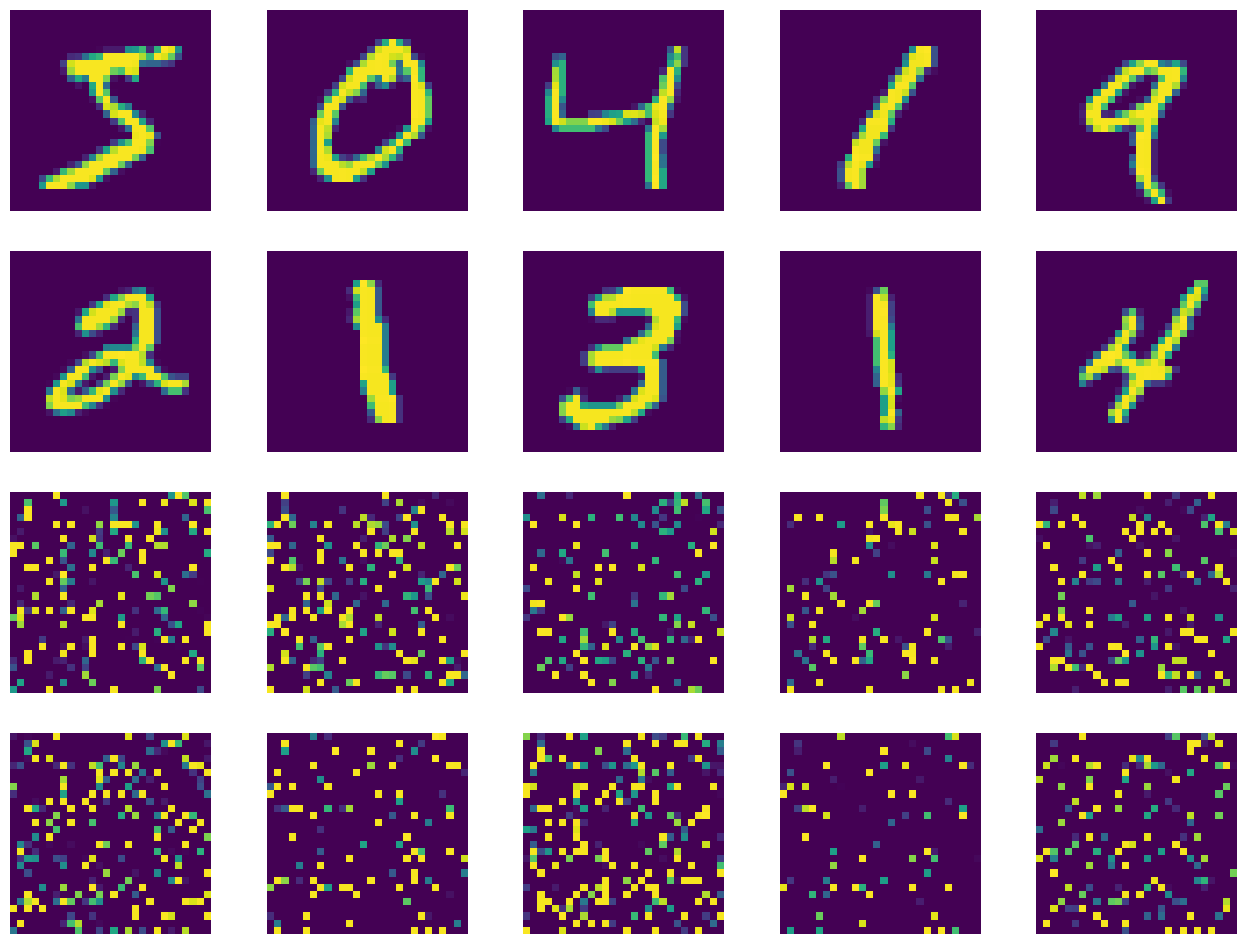

In [62]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28 * 28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis("off")
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis("off")

The figure above demonstrate our "deterministic permutation" : In the 1st two rows, you see the dataset with the structured data (the numbers). In the second dataset, the content is the same but the pixels are "randomly scattered" so there are now structure.

Of course the permutation is deterministic, we always permute the pixels the same way, otherwise nothing woul

First, let's train a CNN

In [64]:
# Training settings
n_features = 6  # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print("Number of parameters: {}".format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.303697
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.295292
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.244230
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.127927
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.939293
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.692011
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.421699
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.090398
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.908350
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.842702

Test set: Average loss: 0.6832, Accuracy: 7843/10000 (78%)



Then, a fully connected neural nets

In [65]:
n_hidden = 8  # number of hidden units

model_fnn = FullyConnected2Layers(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print("Number of parameters: {}".format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.376477
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.957359
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.966119
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.776090
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.652975
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.455262
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.477745
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.543108
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.702572
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.577542

Test set: Average loss: 0.3907, Accuracy: 8830/10000 (88%)



Let's now compare the accuracies of 4 neural networks :
- CNN with image assumption
- FC with image assumption
- CNN without image assumption
- FC with image assumption

**Takeaway messages**

The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

    ConvNet makes the assumption that pixels lie on a grid and are stationary/local
    It loses performance when this assumption is wrong
    The fully-connected network does not make this assumption
    It does less well when it is true, since it doesn't take advantage of this prior knowledge
    But it doesn't suffer when the assumption is wrong

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (5,).

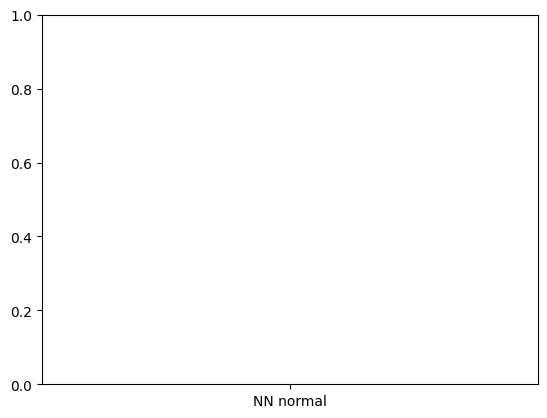

In [68]:
plt.bar(
    ("NN normal", "CNN normal", "CNN scrambled", "NN scrambled"),
    accuracy_list,
    width=0.4,
)
plt.ylim((min(accuracy_list) - 5, 96))
plt.ylabel("Accuracy [%]")
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label1.set_fontsize(10)
plt.title("Performance comparison");